Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Hyperparameter Tuning with HyperDrive - Setup & Preparation

## Introduction
This notebook shows how to setup compute target and other prerequisites for tuning hyperparameters of a deep neural network with HyperDrive in Azure Machine Learning and TensorFlow. We use MNIST dataset, a popular dataset consisting of 70,000 grayscale images, to train, validate, and test the model. In this dataset, each image is a handwritten digit of `28x28` pixels, representing number from 0 to 9. The goal is to create a multi-class classifier to identify the digit each image represents.

For more information about the MNIST dataset, please visit [Yan LeCun's website](http://yann.lecun.com/exdb/mnist/).

## Prerequisite:
* Understand the [architecture and terms](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture) introduced by Azure Machine Learning
* Following the [instructions](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-workspace#create-a-workspace) to create an Azure Machine Learning Workspace in Azure portal and download its configuration file (`config.json`) by clicking the Download config.json in the workspace overview
![DownloadConfigFile](workspace_config.png)
* Upload config.json to /hyperdrive folder of this Azure Notebook project

Let's get started. First let's import some Python libraries.

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
import azureml
from azureml.core import Workspace

# Check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.33


In [3]:
notebook_dir = os.getcwd()
sys.path.append(os.path.dirname(notebook_dir))

from src import config

## Diagnostics
Opt-in diagnostics for better experience, quality, and security of future releases.

In [4]:
from azureml.telemetry import set_diagnostics_collection

set_diagnostics_collection(send_diagnostics=True)

Turning diagnostics collection on. 


## Initialize workspace
Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.

In [5]:
ws = Workspace.from_config()

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FH9SY4T2W to authenticate.
Interactive authentication successfully completed.


## Create an Azure ML experiment
Let's create an experiment named "tf-mnist" and a folder to hold the training scripts. The script runs will be recorded under the experiment in Azure.

In [9]:
from azureml.core import Experiment

script_folder = './tf-mnist'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='tf-mnist-hp0605')

## Load MNIST dataset
We will use the MNIST dataset stored in `data` folder for the experiments. The dataset includes 6 files for model training, validation, and testing.

In [7]:
os.listdir('./data/mnist')

['X_test.npy',
 'y_train.npy',
 'X_valid.npy',
 'y_test.npy',
 'X_train.npy',
 'y_valid.npy']

In [10]:
X_test = np.load("./data/mnist/X_test.npy")
y_test = np.load("./data/mnist/y_test.npy")

## Show some sample images
Let's load the downloaded compressed file into numpy arrays using some utility functions included in the `utils.py` library file from the current folder. Then we use `matplotlib` to plot 30 random images from the dataset along with their labels.

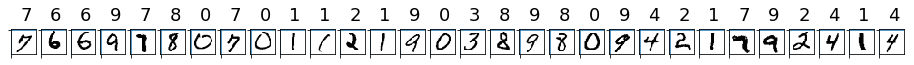

In [11]:
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_test.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_test[i], fontsize = 18)
    plt.imshow(X_test[i].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

## Upload MNIST dataset to default datastore 
A [datastore](https://docs.microsoft.com/azure/machine-learning/service/how-to-access-data) is a place where data can be stored that is then made accessible to a Run either by means of mounting or copying the data to the compute target. A datastore can either be backed by an Azure Blob Storage or and Azure File Share (ADLS will be supported in the future). For simple data handling, each workspace provides a default datastore that can be used, in case the data is not already in Blob Storage or File Share.

In [13]:
ds = ws.get_default_datastore()

In this next step, we will upload the training and test set into the workspace's default datastore, which we will then later be mount on an `AmlCompute` cluster for training.

In [14]:
ds.upload(src_dir='./data/mnist', target_path='mnist-hp', overwrite=True, show_progress=True)

Uploading ./data/mnist/X_test.npy
Uploading ./data/mnist/y_train.npy
Uploading ./data/mnist/X_valid.npy
Uploading ./data/mnist/y_test.npy
Uploading ./data/mnist/X_train.npy
Uploading ./data/mnist/y_valid.npy
Uploaded ./data/mnist/y_train.npy, 1 files out of an estimated total of 6
Uploaded ./data/mnist/y_valid.npy, 2 files out of an estimated total of 6
Uploaded ./data/mnist/y_test.npy, 3 files out of an estimated total of 6
Uploaded ./data/mnist/X_test.npy, 4 files out of an estimated total of 6
Uploaded ./data/mnist/X_valid.npy, 5 files out of an estimated total of 6
Uploaded ./data/mnist/X_train.npy, 6 files out of an estimated total of 6


$AZUREML_DATAREFERENCE_b9e9e59ddef440dc9277b4e6fdab03eb

## Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for training your model. In this tutorial, you create `AmlCompute` as your training compute resource.

If we could not find the cluster with the given name, then we will create a new cluster here. We will create an `AmlCompute` cluster of `STANDARD_NC6` GPU VMs. This process is broken down into 3 steps:
1. create the configuration (this step is local and only takes a second)
2. create the cluster (this step will take about **20 seconds**)
3. provision the VMs to bring the cluster to the initial size (of 1 in this case). This step will take about **3-5 minutes** and is providing only sparse output in the process. Please make sure to wait until the call returns before moving to the next cell

In [15]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size=config.compute['vm_size'], 
                                                           max_nodes=config.compute['max_nodes'])

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, 
                                       min_node_count=None, 
                                       timeout_in_minutes=config.compute['timeout_in_minutes'])

# use get_status() to get a detailed status for the current cluster. 
#print(compute_target.get_status().serialize())

Found existing compute target


Now that you have created the compute target, let's see what the workspace's `compute_targets` property returns. You should now see one entry named 'gpucluster' of type `AmlCompute`.

In [16]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

amlaks17ba69999 AKS Failed
NB-VM-T1 VirtualMachine Succeeded
gpucluster AmlCompute Succeeded
cpucluster AmlCompute Succeeded
cpucluster-2 AmlCompute Succeeded
aml-compute AmlCompute Succeeded
gpucompute AmlCompute Succeeded


## Copy the training files into the script folder
The TensorFlow training script is already created for you. You can simply copy it into the script folder, together with the utility library used to load compressed data file into numpy array.

In [17]:
import shutil

# The training logic is in the tf_mnist.py file.
shutil.copy('./tf_mnist.py', script_folder)

'./tf-mnist/tf_mnist.py'

## Construct neural network in TensorFlow
In the training script `tf_mnist.py`, it creates a very simple DNN (deep neural network), with just 2 hidden layers. The input layer has 28 * 28 = 784 neurons, each representing a pixel in an image. The first hidden layer has 300 neurons, and the second hidden layer has 100 neurons. The output layer has 10 neurons, each representing a targeted label from 0 to 9.

![DNN](nn.png)

### Azure ML concepts  
Please note the following three things in the code below:
1. The script accepts arguments using the argparse package. In this case there is one argument `--data_folder` which specifies the file system folder in which the script can find the MNIST data
```
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_folder')
```
2. The script is accessing the Azure ML `Run` object by executing `run = Run.get_context()`. Further down the script is using the `run` to report the training accuracy and the validation accuracy as training progresses.
```
    run.log('training_acc', np.float(acc_train))
    run.log('validation_acc', np.float(acc_val))
```
3. When running the script on Azure ML, you can write files out to a folder `./outputs` that is relative to the root directory. This folder is specially tracked by Azure ML in the sense that any files written to that folder during script execution on the remote target will be picked up by Run History; these files (known as artifacts) will be available as part of the run history record.

## Create TensorFlow estimator (To save time, you may skip the rest of this notebook and jump into random.ipynb or bayesian.ipynb)

Next, we construct an `azureml.train.dnn.TensorFlow` estimator object, use the Batch AI cluster as compute target, and pass the mount-point of the datastore to the training code as a parameter.

The TensorFlow estimator is providing a simple way of launching a TensorFlow training job on a compute target. It will automatically provide a docker image that has TensorFlow installed -- if additional pip or conda packages are required, their names can be passed in via the `pip_packages` and `conda_packages` arguments and they will be included in the resulting docker.

The TensorFlow estimator also takes a `framework_version` parameter -- if no version is provided, the estimator will default to the latest version supported by AzureML. Use `TensorFlow.get_supported_versions()` to get a list of all versions supported by your current SDK version or see the [SDK documentation](https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.dnn?view=azure-ml-py) for the versions supported in the most current release.

In [21]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': ws.get_default_datastore().as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 40,
    '--second-layer-neurons': 20,
    '--learning-rate': 0.01
}

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target,
                 entry_script='tf_mnist.py', 
                 use_gpu=True, 
                 framework_version='1.12')

## Submit job to run
Submit the estimator to an Azure ML experiment to kick off the execution.

In [22]:
run = exp.submit(est)

### Monitor the Run
As the Run is executed, it will go through the following stages:
1. Preparing: A docker image is created matching the Python environment specified by the TensorFlow estimator and it will be uploaded to the workspace's Azure Container Registry. This step will only happen once for each Python environment -- the container will then be cached for subsequent runs. Creating and uploading the image takes about **5 minutes**. While the job is preparing, logs are streamed to the run history and can be viewed to monitor the progress of the image creation.

2. Scaling: If the compute needs to be scaled up (i.e. the Batch AI cluster requires more nodes to execute the run than currently available), the cluster will attempt to scale up in order to make the required amount of nodes available. Scaling typically takes about **5 minutes**.

3. Running: All scripts in the script folder are uploaded to the compute target, data stores are mounted/copied and the `entry_script` is executed. While the job is running, stdout and the `./logs` folder are streamed to the run history and can be viewed to monitor the progress of the run.

4. Post-Processing: The `./outputs` folder of the run is copied over to the run history

There are multiple ways to check the progress of a running job. We can use a Jupyter notebook widget. 

**Note: The widget will automatically update ever 10-15 seconds, always showing you the most up-to-date information about the run**

In [23]:
from azureml.widgets import RunDetails

RunDetails(run).show() 

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

We can also periodically check the status of the run object, and navigate to Azure portal to monitor the run.

In [ ]:
run

In [ ]:
run.wait_for_completion()

### The Run object
The Run object provides the interface to the run history -- both to the job and to the control plane (this notebook), and both while the job is running and after it has completed. It provides a number of interesting features for instance:
* `run.get_details()`: Provides a rich set of properties of the run
* `run.get_metrics()`: Provides a dictionary with all the metrics that were reported for the Run
* `run.get_file_names()`: List all the files that were uploaded to the run history for this Run. This will include the `outputs` and `logs` folder, azureml-logs and other logs, as well as files that were explicitly uploaded to the run using `run.upload_file()`

Below are some examples -- please run through them and inspect their output. 

In [ ]:
run.get_metrics()

In [ ]:
run.get_file_names()

## Plot accuracy over epochs
Since we can retrieve the metrics from the run, we can easily make plots using `matplotlib` in the notebook. Then we can add the plotted image to the run using `run.log_image()`, so all information about the run is kept together.

In [ ]:
os.makedirs('./imgs', exist_ok=True)
metrics = run.get_metrics()

plt.figure(figsize = (13,5))
plt.plot(metrics['validation_acc'], 'r-', lw=4, alpha=.6)
plt.plot(metrics['training_acc'], 'b--', alpha=0.5)
plt.legend(['Full evaluation set', 'Training set mini-batch'])
plt.xlabel('epochs', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('Accuracy over Epochs', fontsize=16)
run.log_image(name='acc_over_epochs.png', plot=plt)
plt.show()

## Download the saved model

In the training script, a TensorFlow `saver` object is used to persist the model in a local folder (local to the compute target). The model was saved to the `./outputs` folder on the disk of the Batch AI cluster node where the job is run. Azure ML automatically uploaded anything written in the `./outputs` folder into run history file store. Subsequently, we can use the `Run` object to download the model files the `saver` object saved. They are under the the `outputs/model` folder in the run history file store, and are downloaded into a local folder named `model`. Note the TensorFlow model consists of four files in binary format and they are not human-readable.

In [ ]:
from utils import download_model

# Create a model folder in the current directory
os.makedirs('./model', exist_ok=True)

download_model(run, "outputs/model", "./model")

## Predict on the test set

Note: if your local TensorFlow version is different than the version running in the cluster where the model is trained, you might see a "compiletime version mismatch" warning. You can ignore it.

In [ ]:
from src.utils import evaluate

evaluate("./model/mnist-tf.model", X_test, y_test)